<a href="https://colab.research.google.com/github/visshal2301/AdvanceSpark_GoogleColab/blob/main/4_Bucketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from pyspark.storagelevel import StorageLevel
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [ ]:
spark = (
    SparkSession
    .builder
    .config("spark.driver.memory", "10g")
    .master("local[*]")
    .appName("6_0_partitioning")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [ ]:
orders_file  = "/content/drive/MyDrive/data/bucketing/orders.csv"

df_orders = spark.read.csv(orders_file, header=True, inferSchema=True)

In [ ]:
df_orders.show(5, False)
df_orders.printSchema()

+--------+----------+-----------+--------+-------------------+------------+
|order_id|product_id|customer_id|quantity|order_date         |total_amount|
+--------+----------+-----------+--------+-------------------+------------+
|1       |80        |10         |4       |2023-03-20 00:00:00|1003        |
|2       |69        |30         |3       |2023-12-11 00:00:00|780         |
|3       |61        |20         |4       |2023-04-26 00:00:00|1218        |
|4       |62        |44         |3       |2023-08-26 00:00:00|2022        |
|5       |78        |46         |4       |2023-08-05 00:00:00|1291        |
+--------+----------+-----------+--------+-------------------+------------+
only showing top 5 rows

root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- order_date: timestamp (nullable = true)
 |-- total_amount: integer (nullable = true)



In [ ]:
products_file = "/content/drive/MyDrive/data/bucketing/products.csv"
df_products = spark.read.csv(products_file, header=True, inferSchema=True)

In [ ]:
df_products.show(5, False)
df_products.printSchema()

+----------+------------+-----------+-------+-----+-----+
|product_id|product_name|category   |brand  |price|stock|
+----------+------------+-----------+-------+-----+-----+
|1         |Product_1   |Electronics|Brand_4|26   |505  |
|2         |Product_2   |Apparel    |Brand_4|489  |15   |
|3         |Product_3   |Apparel    |Brand_4|102  |370  |
|4         |Product_4   |Groceries  |Brand_1|47   |433  |
|5         |Product_5   |Groceries  |Brand_3|244  |902  |
+----------+------------+-----------+-------+-----+-----+
only showing top 5 rows

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- stock: integer (nullable = true)



In [ ]:
df_products.select(F.col("product_id")).distinct().count()

100

In [ ]:
df_orders.select("order_id").distinct().count()

1000

**Join WithOut Bucket**

In [ ]:
df_orders_product_details = (
    df_orders.join(
        df_products,
        on="product_id",
        how="inner"
    )
)

In [ ]:

df_orders_product_details.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [product_id#65, order_id#64, customer_id#66, quantity#67, order_date#68, total_amount#69, product_name#126, category#127, brand#128, price#129, stock#130]
   +- SortMergeJoin [product_id#65], [product_id#125], Inner
      :- Sort [product_id#65 ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(product_id#65, 200), ENSURE_REQUIREMENTS, [plan_id=290]
      :     +- Filter isnotnull(product_id#65)
      :        +- FileScan csv [order_id#64,product_id#65,customer_id#66,quantity#67,order_date#68,total_amount#69] Batched: false, DataFilters: [isnotnull(product_id#65)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/drive/MyDrive/data/bucketing/orders.csv], PartitionFilters: [], PushedFilters: [IsNotNull(product_id)], ReadSchema: struct<order_id:int,product_id:int,customer_id:int,quantity:int,order_date:timestamp,total_amount...
      +- Sort [product_id#125 ASC NULLS FIRST], false, 0
         

In [ ]:
df_orders_product_details.count()

1000

In [ ]:
(
    df_products
    .write.bucketBy(4, col="product_id")
    .mode("overwrite")
    .saveAsTable("products_bucketed")
)

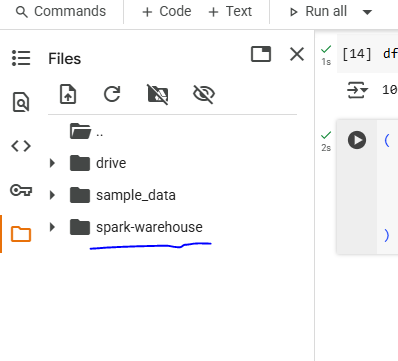

In [ ]:
(
    df_orders
    .write.bucketBy(4, col="product_id")
    .mode("overwrite")
    .saveAsTable("orders_bucketed")
)

In [ ]:
df_orders_bucketed = spark.table("orders_bucketed")
df_products_bucketed = spark.table("products_bucketed")

In [ ]:
df_orders_product_details_bucketed = (
    df_orders_bucketed.join(
        df_products_bucketed,
        on="product_id",
        how="inner"
    )
)

In [ ]:
df_orders_product_details_bucketed.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [product_id#239, order_id#238, customer_id#240, quantity#241, order_date#242, total_amount#243, product_name#251, category#252, brand#253, price#254, stock#255]
   +- SortMergeJoin [product_id#239], [product_id#250], Inner
      :- Sort [product_id#239 ASC NULLS FIRST], false, 0
      :  +- Filter isnotnull(product_id#239)
      :     +- FileScan parquet spark_catalog.default.orders_bucketed[order_id#238,product_id#239,customer_id#240,quantity#241,order_date#242,total_amount#243] Batched: true, Bucketed: true, DataFilters: [isnotnull(product_id#239)], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/spark-warehouse/orders_bucketed], PartitionFilters: [], PushedFilters: [IsNotNull(product_id)], ReadSchema: struct<order_id:int,product_id:int,customer_id:int,quantity:int,order_date:timestamp,total_amount..., SelectedBucketsCount: 4 out of 4
      +- Sort [product_id#250 ASC NULLS FIRST], false, 0
       

In [ ]:
df_orders_product_details_bucketed.count()

1000

**Bucketing In Aggregations**

In [ ]:
df_orders.show(5, False)

+--------+----------+-----------+--------+-------------------+------------+
|order_id|product_id|customer_id|quantity|order_date         |total_amount|
+--------+----------+-----------+--------+-------------------+------------+
|1       |80        |10         |4       |2023-03-20 00:00:00|1003        |
|2       |69        |30         |3       |2023-12-11 00:00:00|780         |
|3       |61        |20         |4       |2023-04-26 00:00:00|1218        |
|4       |62        |44         |3       |2023-08-26 00:00:00|2022        |
|5       |78        |46         |4       |2023-08-05 00:00:00|1291        |
+--------+----------+-----------+--------+-------------------+------------+
only showing top 5 rows



In [ ]:
# WITHOUT BUCKETING

df_product_sales = (
    df_orders
    .groupBy("product_id")
    .agg(F.sum("total_amount").alias("sales"))
)

df_product_sales.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[product_id#65], functions=[sum(total_amount#69)])
   +- Exchange hashpartitioning(product_id#65, 200), ENSURE_REQUIREMENTS, [plan_id=711]
      +- HashAggregate(keys=[product_id#65], functions=[partial_sum(total_amount#69)])
         +- FileScan csv [product_id#65,total_amount#69] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/drive/MyDrive/data/bucketing/orders.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<product_id:int,total_amount:int>




In [ ]:
# WITH BUCKETING

df_product_sales = (
    df_orders_bucketed
    .groupBy("product_id")
    .agg(F.sum("total_amount").alias("sales"))
)

df_product_sales.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[product_id#239], functions=[sum(total_amount#243)])
   +- HashAggregate(keys=[product_id#239], functions=[partial_sum(total_amount#243)])
      +- FileScan parquet spark_catalog.default.orders_bucketed[product_id#239,total_amount#243] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/spark-warehouse/orders_bucketed], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<product_id:int,total_amount:int>, SelectedBucketsCount: 4 out of 4




**Bucket Pruning**

In [ ]:
df_product_sales_bucket_pruning = (
    df_orders_bucketed
    .filter(F.col("product_id") == 1)
    .groupBy("product_id")
    .agg(F.sum("total_amount").alias("sales"))
)

In [ ]:
df_product_sales_bucket_pruning.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[product_id#239], functions=[sum(total_amount#243)])
   +- HashAggregate(keys=[product_id#239], functions=[partial_sum(total_amount#243)])
      +- Filter (isnotnull(product_id#239) AND (product_id#239 = 1))
         +- FileScan parquet spark_catalog.default.orders_bucketed[product_id#239,total_amount#243] Batched: true, Bucketed: true, DataFilters: [isnotnull(product_id#239), (product_id#239 = 1)], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/spark-warehouse/orders_bucketed], PartitionFilters: [], PushedFilters: [IsNotNull(product_id), EqualTo(product_id,1)], ReadSchema: struct<product_id:int,total_amount:int>, SelectedBucketsCount: 1 out of 4


